# **Procesado básico de la señal: Cuantización**
## Procesamiento de Imagen y Señal
### **Alan García Justel**
### Curso 2024-2025

In [1]:
import math
import cmath

import os
import sys

##

import warnings
warnings.filterwarnings('ignore')

##

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as im

from scipy import signal, fftpack, ndimage
from scipy.fft import fft, ifft

import scipy.signal as sp_s
import scipy.io as sp_io

from scipy.signal import chirp, spectrogram
from scipy.io import wavfile

from sklearn.cluster import KMeans

from collections import Counter

### Audio
from IPython.display import Image, HTML, display
import IPython.display as ipd
import librosa
import librosa.display

from pydub import AudioSegment
from pydub.effects import normalize
from pydub.playback import play

import soundfile as sf

#### Important tips
# To hear the signal
# ipd.Audio(x, rate=fs)
####

### Image
from PIL import Image

from skimage import io, transform

In [ ]:
sys.path.append(os.getcwd())

# Funciones auxiliares
path = "code/"

# Add the directory containing your module to the Python path (wants absolute paths)
sys.path.append(os.path.abspath(path))

from f_audio_player_list import *
from f_plot import *

from f_get_random import *

In [2]:
def q_midrise(x, Q):
    x = np.copy(x)
    idx = np.where(np.abs(x) >= 1)
    x[idx] = np.sign(x[idx])
    # linear uniform quantization
    xQ = Q * (np.floor(x / Q) + 0.5)
    return xQ

def q_midtread(x, w):
    # quantization step
    Q = 1 / (2 ** (w - 1))
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization
    xQ = Q * np.floor(x / Q + 1 / 2)
    return xQ

def requantization(x, xQ):
    e = xQ - x
    # SNR
    SNR = 10 * np.log10(np.var(x) / np.var(e))
    print("SNR: {:2.1f} dB".format(SNR))
    # normalize error
    e = 0.2 * e / np.max(np.abs(e))
    return e

def plot_requantization(x, xQ, e, desde=None, ax=None, titulo=None):
    if desde is None:
        desde = math.floor(len(x)/2)
    if ax is None:
        ax = plt.gca()
    if titulo is None:
        titulo = " "
    ax.plot(x[desde : desde + 100], label=r"signal $x[k]$")
    ax.plot(xQ[desde : desde + 100], label=r"requantized signal $x_Q[k]$")
    ax.plot(e[desde : desde + 100], label=r"quantization error $e[k]$")
    ax.set_xlabel(r"sample index $k$")
    ax.set_title(titulo)
    ax.grid()
    ax.legend()

---

1. Oye las siguientes señales de audio grabadas a diferentes tasas de muestreo y con diferentes cuantizaciones ($8$ y $16$ *bits*). Estas señales se encuentran en el directorio `audio_pipeline/`.
    * **`11k-8bit.wav`** : Fichero de audio grabado con una tasa de muestreo de $11$ kHz y una codificación de $8$ *bits* (original en formato `aiff`).
    * **`22k-8bit.wav`** : Fichero de audio grabado con una tasa de muestreo de $22$ kHz y una codificación de $8$ *bits* (original en formato `.aiff`).
    * **`22k-16bit.wav`** : Fichero de audio grabado con una tasa de muestreo de $22$ kHz y una codificación de $16$ *bits* (original en formato `.aiff`).
    * **`44k-8bit.wav`** : Fichero de audio grabado con una tasa de muestreo de $44$ kHz y una codificación de $8$ *bits* (original en formato `.aiff`).
    * **`44k-16bit.wav`** : Fichero de audio grabado con una tasa de muestreo de $44$ kHz y una codificación de $16$ *bits* (original en formato `.aiff`).

    Cuantifica esta última señal `44k-16bit.wav` en $8$, $4$ y $2$ bits y oye los resultados.

In [3]:
def quantize_uniform(x, quant_min=-1.0, quant_max=1.0, quant_level=5):
    """Uniform quantization approach

    Notebook: C2/C2S2_DigitalSignalQuantization.ipynb

    Args:
        x (np.ndarray): Original signal
        quant_min (float): Minimum quantization level (Default value = -1.0)
        quant_max (float): Maximum quantization level (Default value = 1.0)
        quant_level (int): Number of quantization levels (Default value = 5)

    Returns:
        x_quant (np.ndarray): Quantized signal
    """
    x_normalize = (x-quant_min) * (quant_level-1) / (quant_max-quant_min)
    x_normalize[x_normalize > quant_level - 1] = quant_level - 1
    x_normalize[x_normalize < 0] = 0
    x_normalize_quant = np.around(x_normalize)
    x_quant = (x_normalize_quant) * (quant_max-quant_min) / (quant_level-1) + quant_min
    return x_quant

def display_signal_quant(x, number_of_bits):
    quant_level = 2 ** number_of_bits
    x_quant = quantize_uniform(x, quant_min=-1, quant_max=1, quant_level=quant_level)    
    return x_quant

In [ ]:
# Lee la señal de audio, obtén su frecuencia de muestreo y el numero de bits de su cuantificación

In [ ]:
# 11k-8bit.wav
# ...

# 22k-8bit.wav
# ...

# 22k-16bit.wav
# ...

# 44k-8bit.wav
# ...

In [ ]:
display(sf.info("audio_pipeline/44k-16bit.wav"))
y5, fs5 = sf.read("audio_pipeline/44k-16bit.wav")
print(fs5)
ipd.Audio(y5.T, rate=fs5)
# Da un error y por eso hay que trasponer la señal ya que es una señal en estéreo -> print(y5.shape)
# print(y5.shape)

In [ ]:
# 8 bits
# ...

In [ ]:
# 4 bits
# ...

In [ ]:
# 2 bits
# ...

<hr style="border: 1px solid green" />

2. Dada una señal de voz `audio_voz/speech_8k.wav` realiza una recuantización de la señal y evalúa su error.

In [ ]:
x, fs = sf.read("audio_voz/speech.wav")
# normalize sample
x = x / np.max(np.abs(x))

# Recuantizacion a 16bits

# Recuantizacion a 8bits

# Recuantizacion a 6bits

# Recuantizacion a 4bits

# Recuantizacion a 2bits

In [ ]:
# Visualizacion de las diferentes recuantizaciones de la senal

# Oye las diferentes recuantizaciones de la senal

<hr style="border: 1px solid green" />

3. Generamos una señal sinusoidal ($A = 1$, frecuencia = $500$ Hz) con una frecuencia de muestreo de $32$ kHz. Codifica la señal utilizando 4-bits ($N=4$) donde el tamaño de paso es:
$$\Delta = \frac{\text(rango \ maximo) - \text(rango \ minimo)}{2^N}$$
Dibuja y oye la señal original, la señal cuantificada *mid-rise* y *mid-tread*, y el error de cuantificación para ambas cuantificaciones.

In [ ]:
# Realiza la tarea

In [ ]:
def creaFuncion(t, A=1, f=500, fs=32000):
    # phi = math.pi/2
    # Generar y visualizar
    # y = ...
    # periodo = ...
    # periodo = periodo.astype(int)
    return y, periodo

In [ ]:
t = np.arange(-1, 1, 1.0/fs)

# x, _ = creaFuncion(t)

# Recuantizacion a 4bits (mid-rise)

# Recuantizacion a 4bits (mid-tread)

# Visualiza las diferentes recuantizaciones

<hr style="border: 1px solid green" />

4. Reduce el color de la imagen según el cuestionario:
      + `data_RS/Forest-fragmentation-in-the-Brazilian-Amazon.-Photo-courtesy-of-NASA.jpg` ([**link**](https://imgs.mongabay.com/wp-content/uploads/sites/20/2016/10/01181527/Forest-fragmentation-in-the-Brazilian-Amazon.-Photo-courtesy-of-NASA.jpg)) 
      + que se encuentra en la dirección ([**link**](https://eoimages.gsfc.nasa.gov/images/imagerecords/6000/6811/Brazil_TMO_2006179_lrg.jpg))
      + que se encuentra en la dirección ([**link**](https://live.staticflickr.com/861/28779502307_dba5f6070f_c_d.jpg))
      + que se encuentra en la dirección ([**link**](https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150656/southpacific_vir_2022325_lrg.jpg))

In [ ]:
# Seleccionamos la imagen
seleccionada = get_random_number([0, 3])
print(seleccionada)

In [5]:
# Informacion de una imagen: print_sumario(IMAGEN, NOMBRE, LISTA CANALES)
def print_sumario(im, im_nombre, etiquetas):
    print('--------------')
    print('Detalles de la imagen: '+im_nombre)
    print('--------------')
    print(f'Dimensiones de la imagen: {im.shape}')
    print('Canales:')
    
    if len(etiquetas) == 1:
        im = im[..., np.newaxis]
        
    for i, lab in enumerate(etiquetas):
        min_val = np.min(im[:,:,i])
        max_val = np.max(im[:,:,i])
        print(f'{lab} : min={min_val:.4f}, max={max_val:.4f}')

In [6]:
def RGB_HEX(color):
     return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [7]:
def quantify_colors(im, n_colores):
    """Quantify the colors of imagen
      
    Args: 
        im: image
        n_colores: number of colors
    """
    (h,w,c) = im.shape
    im_r    = im.reshape(h*w, c)
    modelo  = KMeans(n_clusters = n_colores)
    etiquetas = modelo.fit_predict(im_r)
    counts    = Counter(etiquetas)
    counts    = dict(sorted(counts.items()))
    centros   = np.array(modelo.cluster_centers_)
    colores   = np.array([centros[i] for i in counts.keys()])*255.0
    colores_hex = np.array([RGB_HEX(colores[i]) for i in counts.keys()])
    paleta = np.uint8(colores)
    im_q = paleta[etiquetas.flatten()]
    im_q = im_q.reshape(im.shape)
    return counts, paleta, colores_hex, im_q

In [8]:
def plot_RS_quant(im, im4, im8, colores_hex4, valores4, colores_hex8, valores8):
    fig = plt.figure(figsize=(15.1, 9), layout="constrained")
    spec = fig.add_gridspec(2, 3)

    ax0 = fig.add_subplot(spec[1,1])
    ax0.bar(colores_hex4, valores4, color = colores_hex4)
    ax1 = fig.add_subplot(spec[1,2])
    ax1.pie(valores8, labels = colores_hex8, colors = colores_hex8)
    ax2 = fig.add_subplot(spec[0,0])
    ax2.imshow(im)
    ax2.axis('off')
    ax3 = fig.add_subplot(spec[0,1])
    ax3.imshow(im4)
    ax3.axis('off')
    ax4 = fig.add_subplot(spec[0,2])
    ax4.imshow(im8)
    ax4.axis('off')
    
    plt.show()

In [9]:
imagenes = ["data_RS/Forest-fragmentation-in-the-Brazilian-Amazon.-Photo-courtesy-of-NASA.jpg", 
            "https://eoimages.gsfc.nasa.gov/images/imagerecords/6000/6811/Brazil_TMO_2006179_lrg.jpg",
            "https://live.staticflickr.com/861/28779502307_dba5f6070f_c_d.jpg",
            "https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150656/southpacific_vir_2022325_lrg.jpg"]

In [ ]:
### Notas sobre las imagenes

# Nota: No hemos podido descargar la imagen mediante el comando de lectura
# https://imgs.mongabay.com/wp-content/uploads/sites/20/2016/10/01181527/Forest-fragmentation-in-the-Brazilian-Amazon.-Photo-courtesy-of-NASA.jpg
# Amazonas

# https://eoimages.gsfc.nasa.gov/images/imagerecords/6000/6811/Brazil_TMO_2006179_lrg.jpg
# Amazonas

# https://live.staticflickr.com/861/28779502307_dba5f6070f_c_d.jpg
# https://www.flickr.com/photos/europeanspaceagency/28779502307/
# Sharm El Sheikh

# https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150656/southpacific_vir_2022325_lrg.jpg
# Pacifico Sur
# Informacion de una imagen

In [ ]:
# Lee la imagen: io.imread()
# Redimensionar la imagen a un tamano de 450x450: transform.resize()
# Imprimir la informacion de la imagen y de sus canales ['R', 'G', 'B']: print_sumario()
# Cuantificar los colores (4 colores)
# Cuantificar los colores (8 colores)
# Dibujar en un diagrama de barras (bar) o en una grafica de pastel (pie)

# fig = plt.figure(figsize=(12.1, 7), layout="constrained")

(450, 450, 3)
--------------
Detalles de la imagen: southpacific
--------------
Dimensiones de la imagen: (450, 450, 3)
Canales:
R : min=0.0000, max=0.9984
G : min=0.0498, max=0.9978
B : min=0.0506, max=0.9988


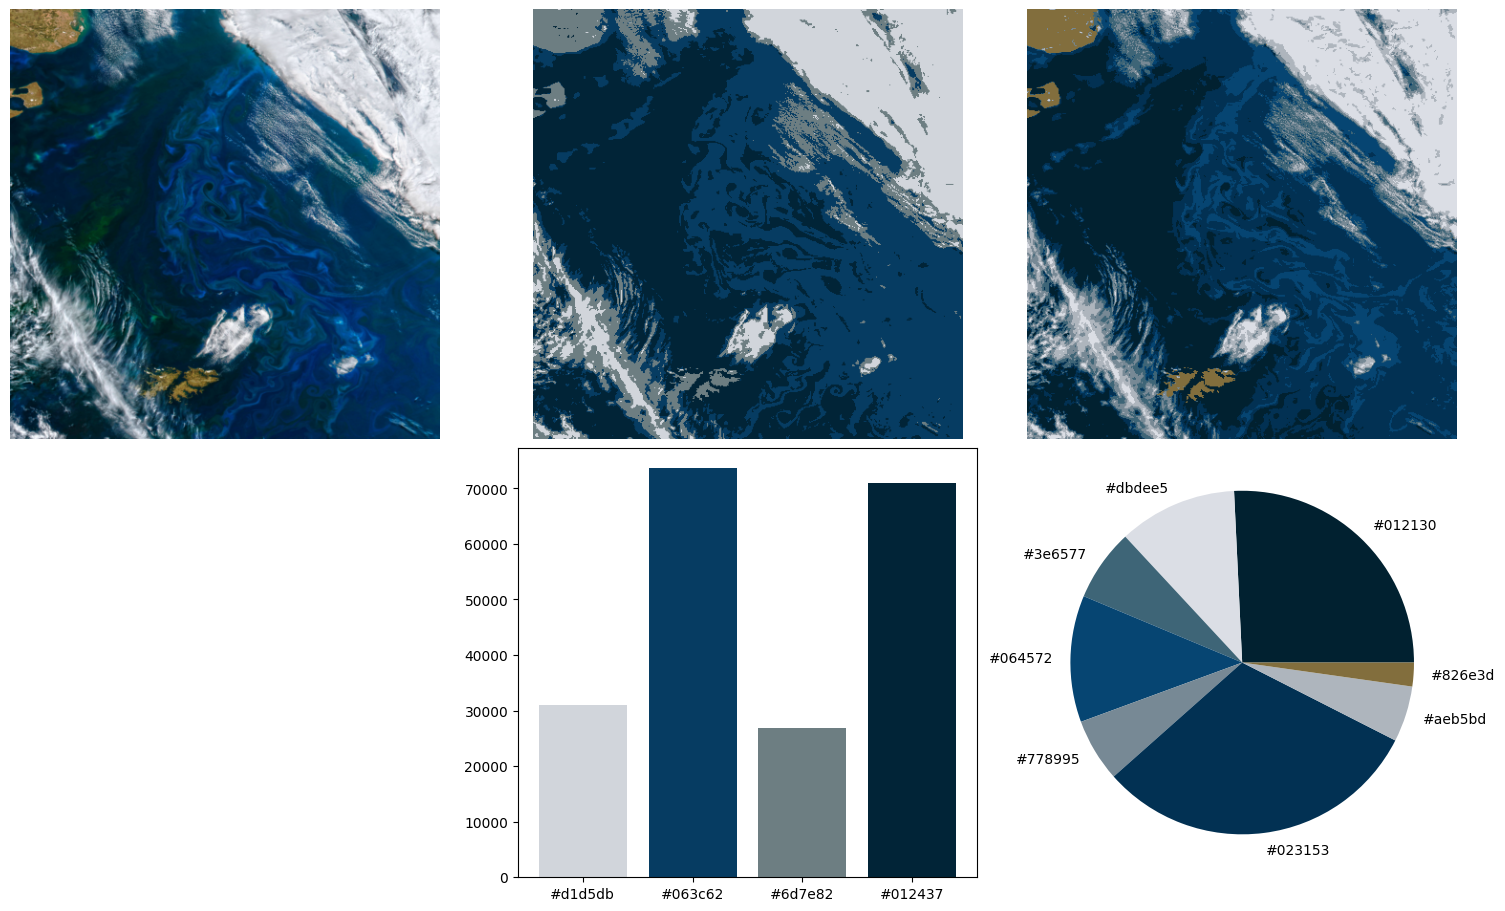

In [21]:
im = io.imread(imagenes[3])
im = transform.resize(im, (450, 450))

# Imprime el sumario de la imagen 
print(im.shape)
print_sumario(im, im_nombre="southpacific", etiquetas=['R', 'G', 'B'])

# Cuantificacion del color (4 colores)
# Ejecutar: quantify_colors()

counts4, paleta, colores_hex4, im4 = quantify_colors(im, n_colores=4)
valores4 = list(counts4.values())

# Cuantificacion del color (8 colores)
# Ejecutar: quantify_colors()
counts8, paleta, colores_hex8, im8 = quantify_colors(im, n_colores=8)
valores8 = list(counts8.values())

# Dibujar: plot_RS_quant()
# Nota: valores = list(counts.values())
plot_RS_quant(im, im4, im8, colores_hex4=colores_hex4, colores_hex8=colores_hex8, valores4=valores4, valores8=valores8)